In [55]:
# 필요한 라이브러리 설치 및 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats as spst
import statsmodels.api as sm
import joblib

# 더 필요한 라이브러리를 아래에 추가합니다.

import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor,RandomForestRegressor,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

## 1. Data Load

In [12]:
open = pd.read_csv('./open_data.csv')
weather = pd.read_csv('./weather.csv')

In [13]:
open.head(2)

,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611


In [14]:
weather.head(2)

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2012-01-01,0.4,-6.6,0.0,77.0,45.0,4.90
1,2012-01-02,-1.2,-8.3,0.0,80.0,48.0,6.16


In [15]:
open.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기준일     2922 non-null   object 
 1   차량운행    2922 non-null   int64  
 2   접수건     2922 non-null   int64  
 3   탑승건     2922 non-null   int64  
 4   평균대기시간  2922 non-null   float64
 5   평균요금    2922 non-null   int64  
 6   평균승차거리  2922 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 159.9+ KB


In [16]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4018 non-null   object 
 1   temp_max         4018 non-null   float64
 2   temp_min         4018 non-null   float64
 3   rain(mm)         4018 non-null   float64
 4   humidity_max(%)  4018 non-null   float64
 5   humidity_min(%)  4018 non-null   float64
 6   sunshine(MJ/m2)  4018 non-null   float64
dtypes: float64(6), object(1)
memory usage: 219.9+ KB


## 2. EDA

In [17]:
open.rename(columns={'기준일' : 'Date',
                     '차량운행' : 'taxi',
                     '접수건' : 'call',
                     '탑승건' : 'board',
                     '평균대기시간' : 'wait_time',
                     '평균요금' : 'fare',
                     '평균승차거리' : 'dist'}, inplace=True)

In [18]:
weather['Date'] = pd.to_datetime(weather['Date'])
open['Date'] = pd.to_datetime(open['Date'])

In [19]:
# 날씨 데이터를 택시운행 데이터와 맞추기 위해 하루전으로 수정
weather['Date'] = weather['Date'].apply(lambda x : x - pd.Timedelta(days=1))

In [20]:
df = pd.merge(open, weather, how='inner', on='Date')

In [21]:
# target 생성
df['target'] = df['wait_time'].shift(1)

In [22]:
# 날짜 변수 생성
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['weekday'] = df['Date'].dt.day_of_week
df['season'] = np.where(df['month'].isin([3,4,5]), 'Spring',
                           np.where(df['month'].isin([6,7,8]), 'Summer',
                                    np.where(df['month'].isin([9,10,11]), 'Fall', 'Winter')))
df['season'] = pd.Categorical(df['season'], categories=['Spring','Summer','Fall','Winter'])

In [23]:
from workalendar.asia import SouthKorea

cal = SouthKorea()
holiday = pd.DataFrame()
for y in range(2015, 2023) :
    holiday = pd.concat([holiday, pd.DataFrame(cal.holidays(y))], axis = 0)

holiday.columns = ['Date', 'holiday']
holiday['Date'] = pd.to_datetime(holiday['Date'])
holiday['holiday'] = 1
holiday.head(3)

,Date,holiday
0,2015-01-01,1
1,2015-02-18,1
2,2015-02-19,1


In [24]:
# holiday : 해당일 휴일 여부 / next_holiday : 다음날 휴일 여부
df = pd.merge(df, holiday, how = 'left')
df.loc[df['weekday'].isin([5, 6]), 'holiday'] = 1
df = df.fillna({'holiday':0})
df['next_holiday'] = df['holiday'].shift(-1)

In [25]:
# 파생변수 생성
df['waiting_avg7'] = df['wait_time'].rolling(7).mean()
df['waiting_avg3'] = df['wait_time'].rolling(3).mean()
df['cancel'] = df['call'] - df['board']
df['temp_diff'] = df['temp_max'] - df['temp_min']
df['humidity_diff'] = df['humidity_max(%)'] - df['humidity_min(%)']
df['board_rate'] = df['board'] / df['call']
df['call_rate'] = df['call'] / df['taxi']
df['unit_charge'] = df['fare'] / df['dist']
df['board_taxi_rate'] = df['board'] / df['taxi']

In [26]:
dummies_cols = ['season']

In [27]:
df = pd.get_dummies(df, columns=dummies_cols, dtype=int)

<Axes: ylabel='taxi'>

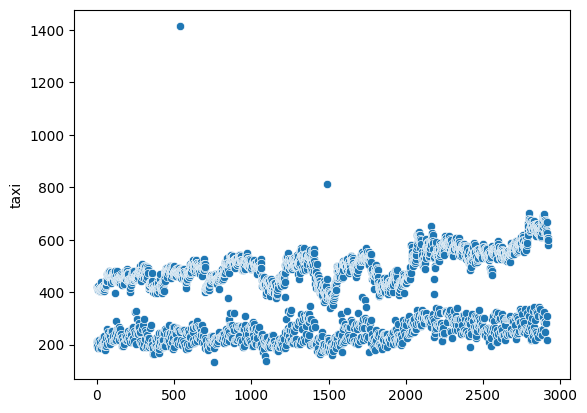

In [28]:
sns.scatterplot(df['taxi'])

In [29]:
# 이상치 처리
df.drop(df[df['taxi'] > 800].index, inplace=True)

In [30]:
df.dropna(inplace=True)

In [31]:
train = df[df['Date'] < '2022-10-01']
test = df[df['Date'] > '2022-09-30']

## 3. Modeling

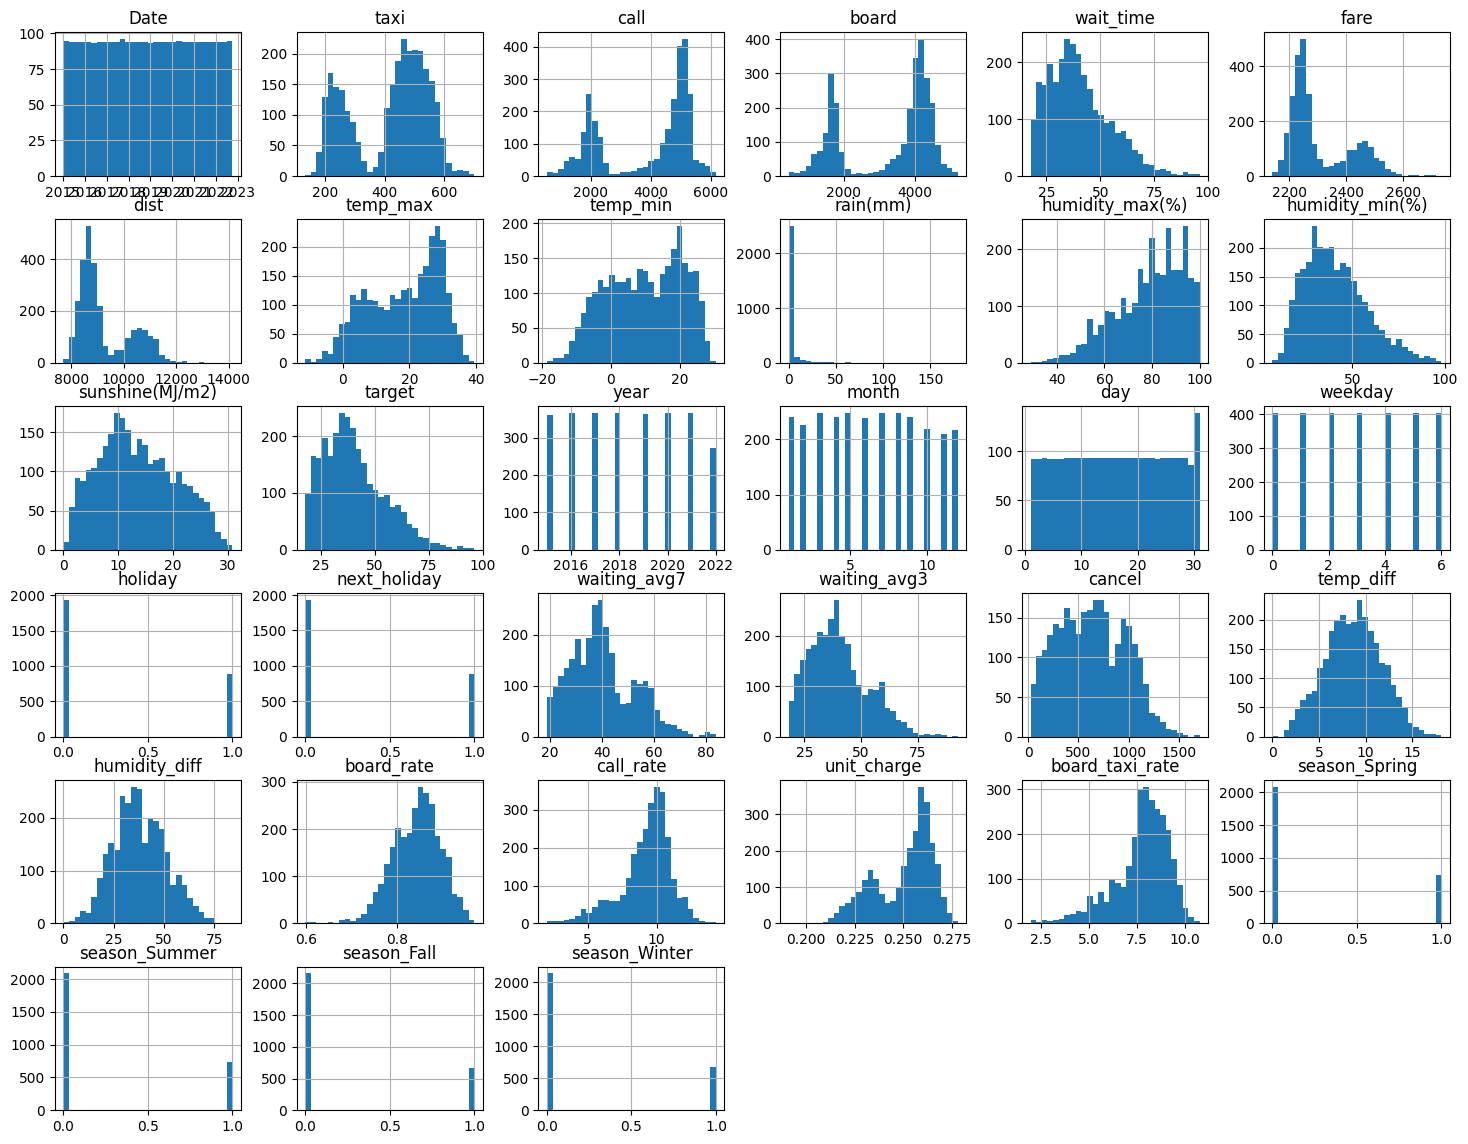

In [32]:
train.hist(bins=30, figsize=(18, 14))
plt.show()

In [56]:
target_log = ['fare', 'dist', 'waiting_avg7', 'waiting_avg3', 'wait_time', 'rain(mm)']

In [57]:
log_train = train.copy()
log_test = test.copy()

In [58]:
log_train[target_log] = np.log1p(log_train[target_log])
log_test[target_log] = np.log1p(log_test[target_log])

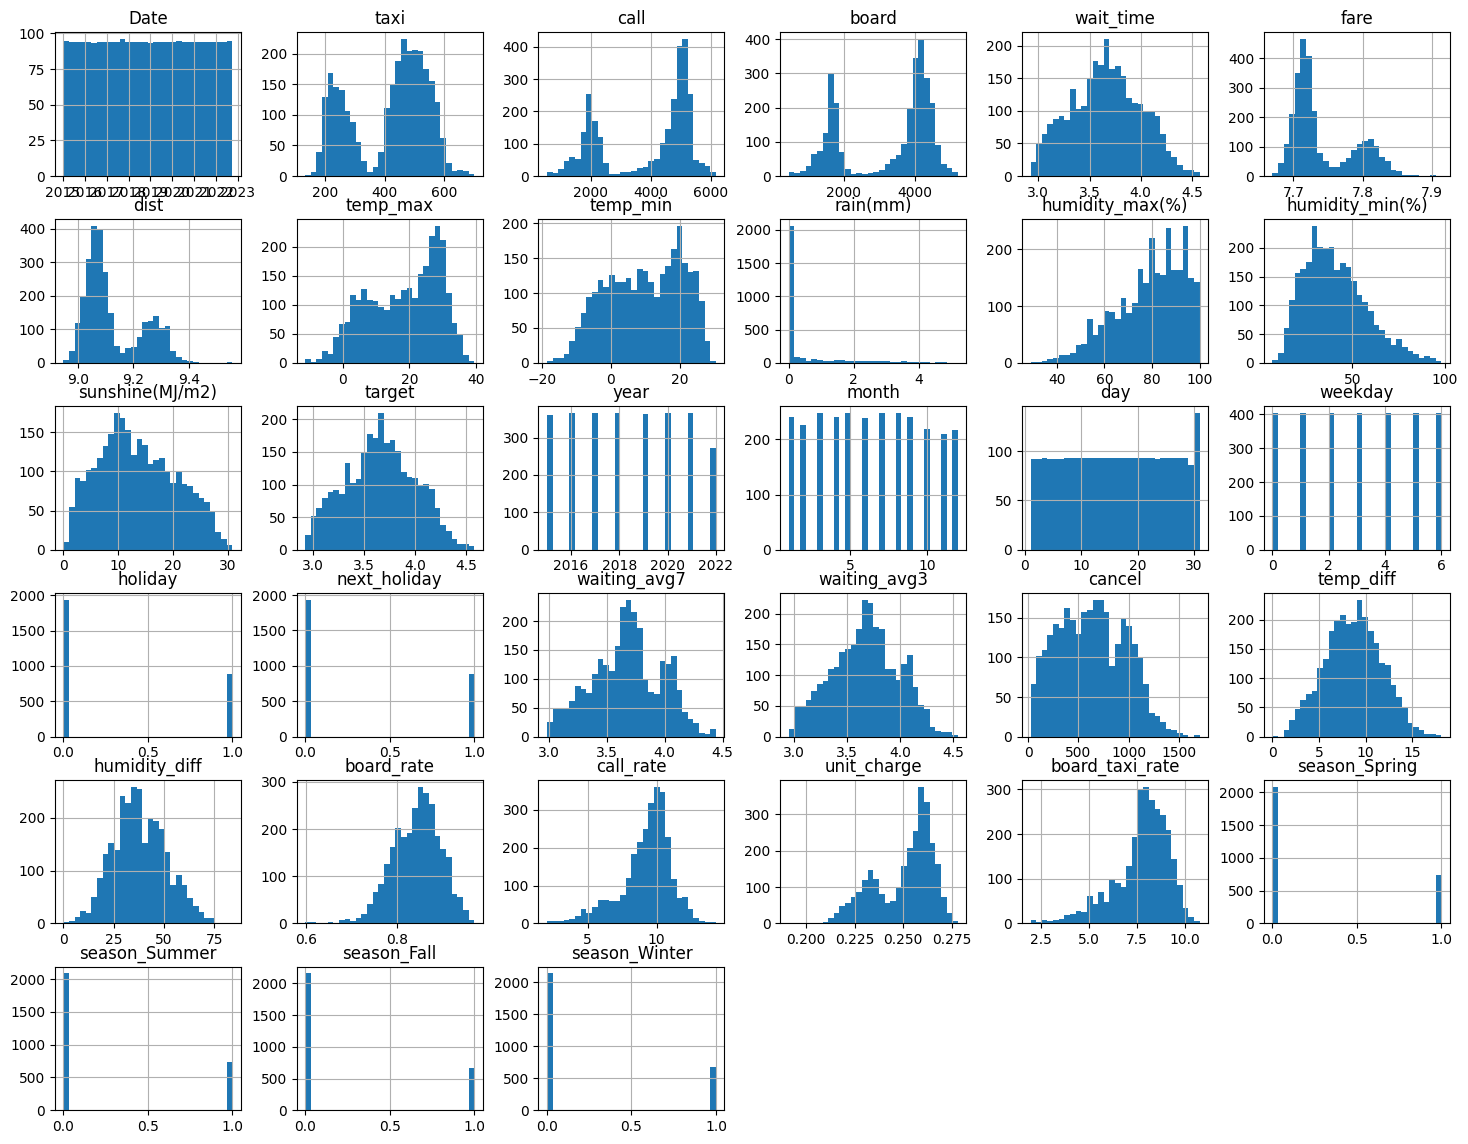

In [36]:
log_train.hist(bins=30, figsize=(18, 14))
plt.show()

In [37]:
target = 'target'
train_x = train.drop([target, 'Date'], axis=1)
train_y = train.loc[:, target]

test_x = test.drop([target, 'Date'], axis=1)
test_y = test.loc[:, target]

In [38]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2823, 31), (2823,), (90, 31), (90,))

In [59]:
target = 'target'
log_train_x = log_train.drop([target, 'Date'], axis=1)
log_train_y = log_train.loc[:, target]

log_test_x = log_test.drop([target, 'Date'], axis=1)
log_test_y = log_test.loc[:, target]

In [40]:
log_train_x.shape, log_train_y.shape, log_test_x.shape, log_test_y.shape

((2823, 31), (2823,), (90, 31), (90,))

In [41]:
# 모델별 파라미터 정의
lgb_params = {
    'metric': 'mean_absolute_percentage_error',
    'random_state': 42
}

xgb_optuna = {
    'metric' : 'mean_absolute_percentage_error',
    'random_state': 42
}

cat_params = {
    'eval_metric': 'MAPE',
}

random_params = {
    'criterion' : 'absolute_error'
}

decision_params = {
    "criterion":'absolute_error',  
    "random_state":42,
}

gbr_params = {
    "criterion" : 'friedman_mse'
    
}
linear_params = {
    "n_jobs" : -1
}
sgd_params = {
    'penalty' : 'l2',
    'early_stopping' : True
}

In [60]:
# 모델 선언
models = {
    'LGBM': LGBMRegressor(**lgb_params),
    'XGB': XGBRegressor(**xgb_optuna), 
    'Cat': CatBoostRegressor(**cat_params),
    'RF': RandomForestRegressor(**random_params),
    'Hist':HistGradientBoostingRegressor(),
    'Decision':DecisionTreeRegressor(**decision_params),
    'GBR':GradientBoostingRegressor(**gbr_params),
    'KNN':KNeighborsRegressor(),
    'linear' : LinearRegression(),
    'SVR' : SVR(kernel='linear')
}

In [53]:
def plot_pred(y_test, y_pred, title):
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4677
[LightGBM] [Info] Number of data points in the train set: 2823, number of used features: 31
[LightGBM] [Info] Start training from score 40.228587


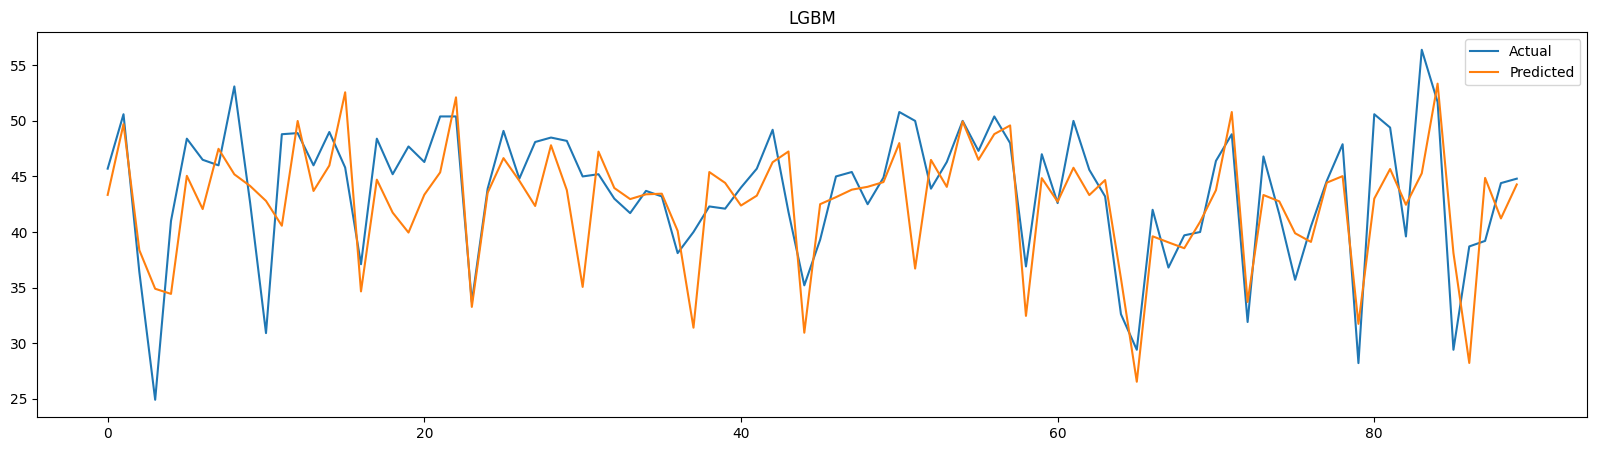

LGBM   RMSE :  4.445135518598336
LGBM   MAPE :  0.08054587978643993
LGBM   MAE :  3.36088480297723
[14:20:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "metric" } are not used.



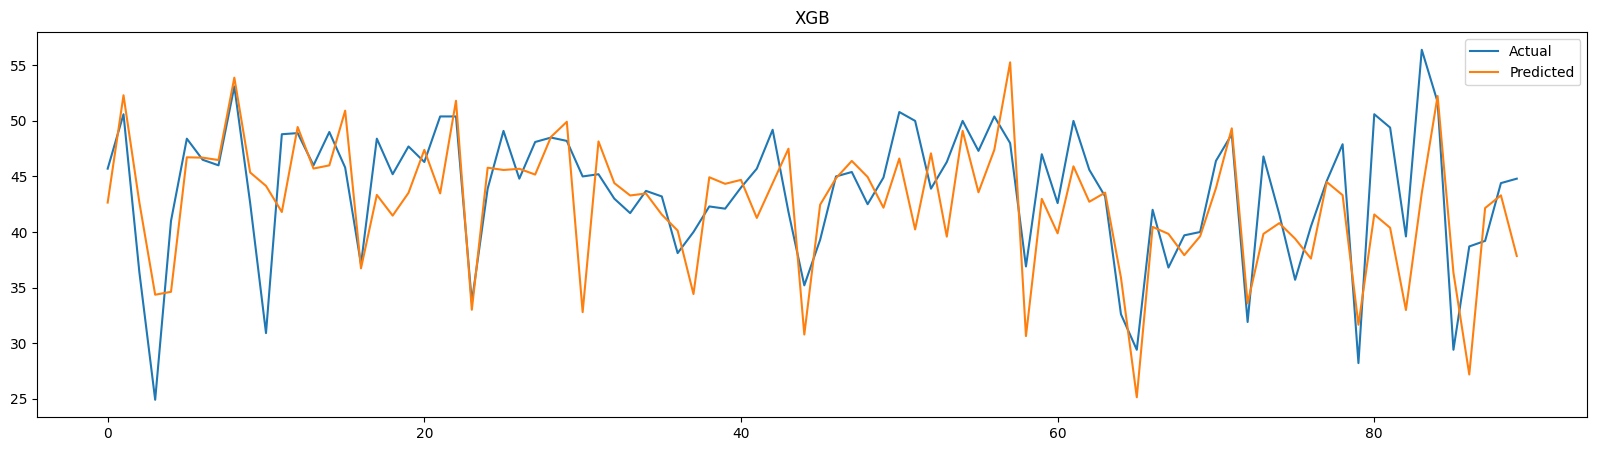

XGB   RMSE :  4.743309632878576
XGB   MAPE :  0.08681570402817268
XGB   MAE :  3.6289298756917314
Learning rate set to 0.048238
0:	learn: 0.3072824	total: 3.41ms	remaining: 3.4s
1:	learn: 0.2963946	total: 5.04ms	remaining: 2.51s
2:	learn: 0.2865014	total: 6.47ms	remaining: 2.15s
3:	learn: 0.2761098	total: 7.78ms	remaining: 1.94s
4:	learn: 0.2664545	total: 9.15ms	remaining: 1.82s
5:	learn: 0.2576555	total: 10.3ms	remaining: 1.71s
6:	learn: 0.2489916	total: 11.8ms	remaining: 1.67s
7:	learn: 0.2406668	total: 13.7ms	remaining: 1.7s
8:	learn: 0.2330875	total: 15.5ms	remaining: 1.71s
9:	learn: 0.2255903	total: 17.1ms	remaining: 1.69s
10:	learn: 0.2183178	total: 19.3ms	remaining: 1.73s
11:	learn: 0.2117782	total: 21ms	remaining: 1.73s
12:	learn: 0.2051960	total: 22.5ms	remaining: 1.71s
13:	learn: 0.1997405	total: 24.7ms	remaining: 1.74s
14:	learn: 0.1940442	total: 26ms	remaining: 1.71s
15:	learn: 0.1879965	total: 28.5ms	remaining: 1.75s
16:	learn: 0.1826461	total: 30.2ms	remaining: 1.74s
17:	

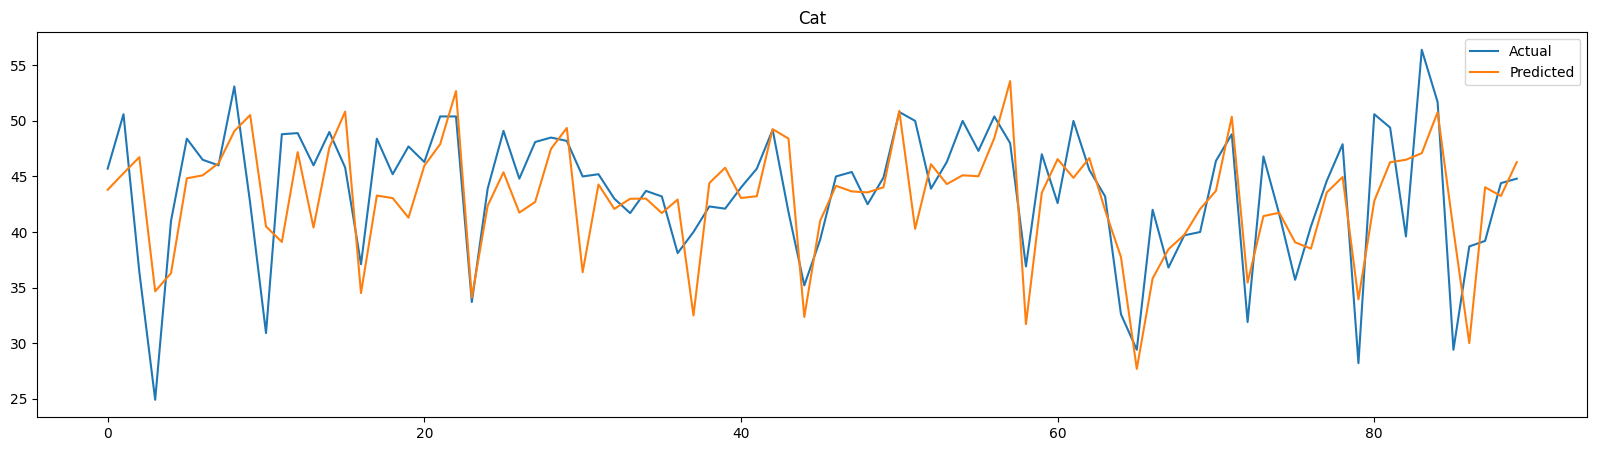

Cat   RMSE :  4.533563815582474
Cat   MAPE :  0.08623286133927127
Cat   MAE :  3.5564352720198906


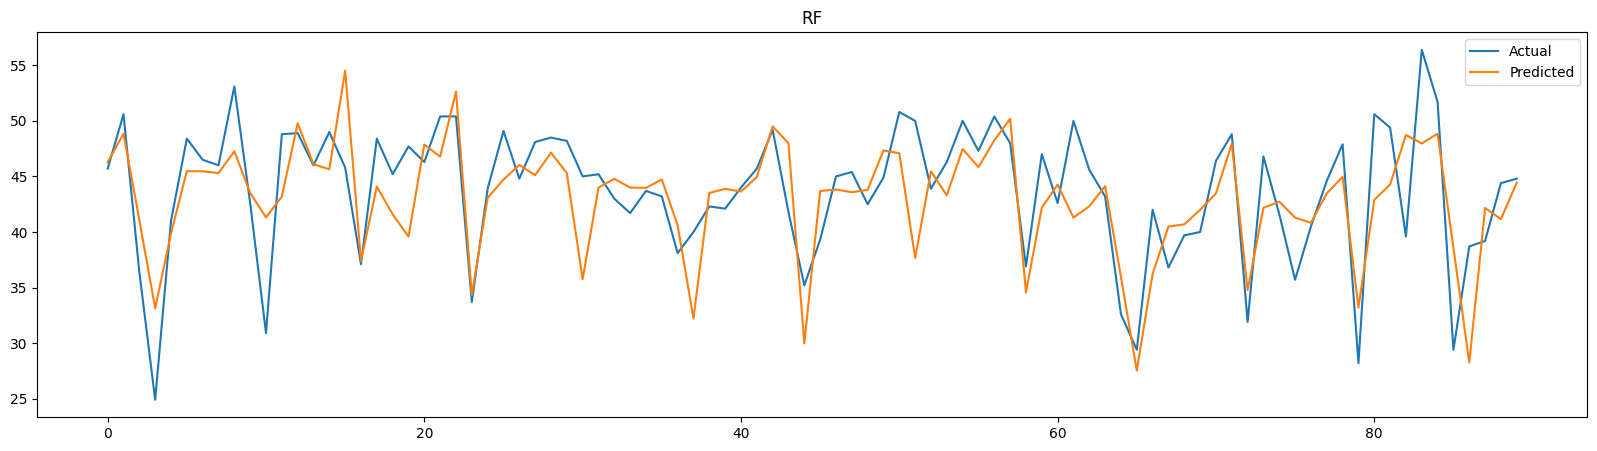

RF   RMSE :  4.399379968308666
RF   MAPE :  0.08093286315830633
RF   MAE :  3.3739333333333343


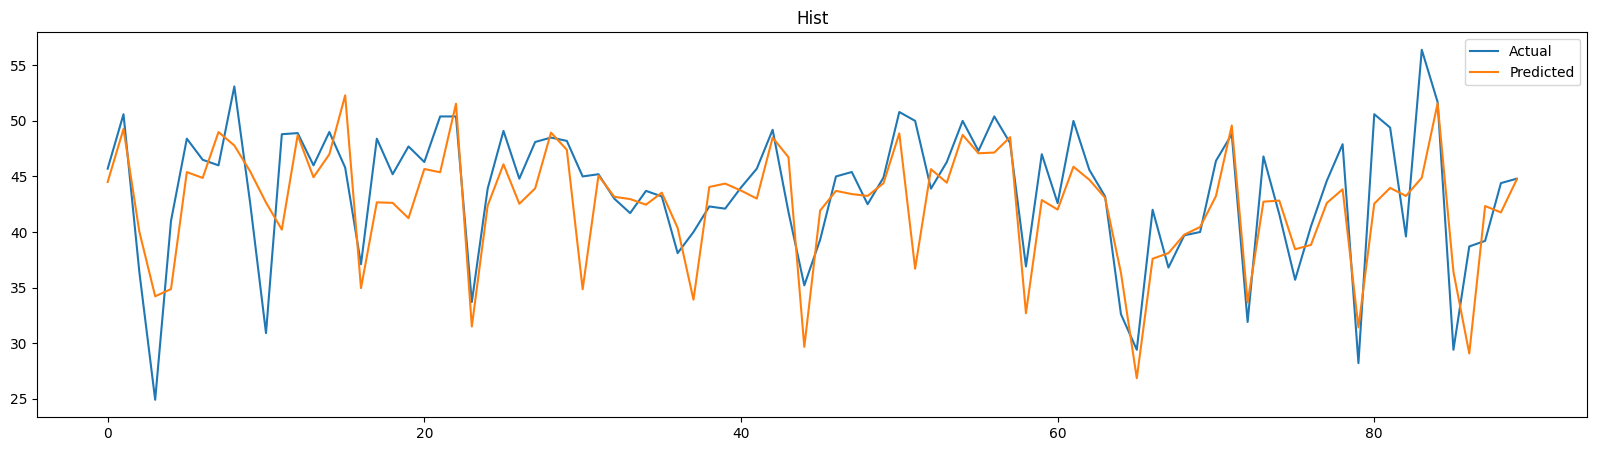

Hist   RMSE :  4.2278232314800235
Hist   MAPE :  0.07452462740983568
Hist   MAE :  3.1023497610268667


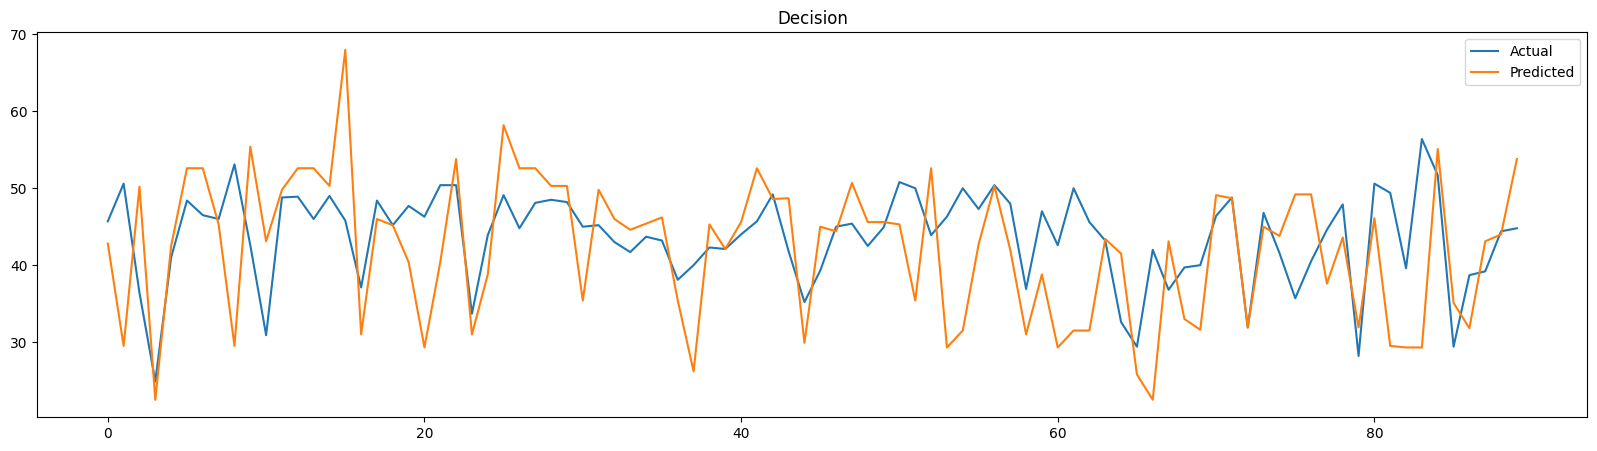

Decision   RMSE :  9.209011287260369
Decision   MAPE :  0.15752120125207358
Decision   MAE :  6.890000000000001


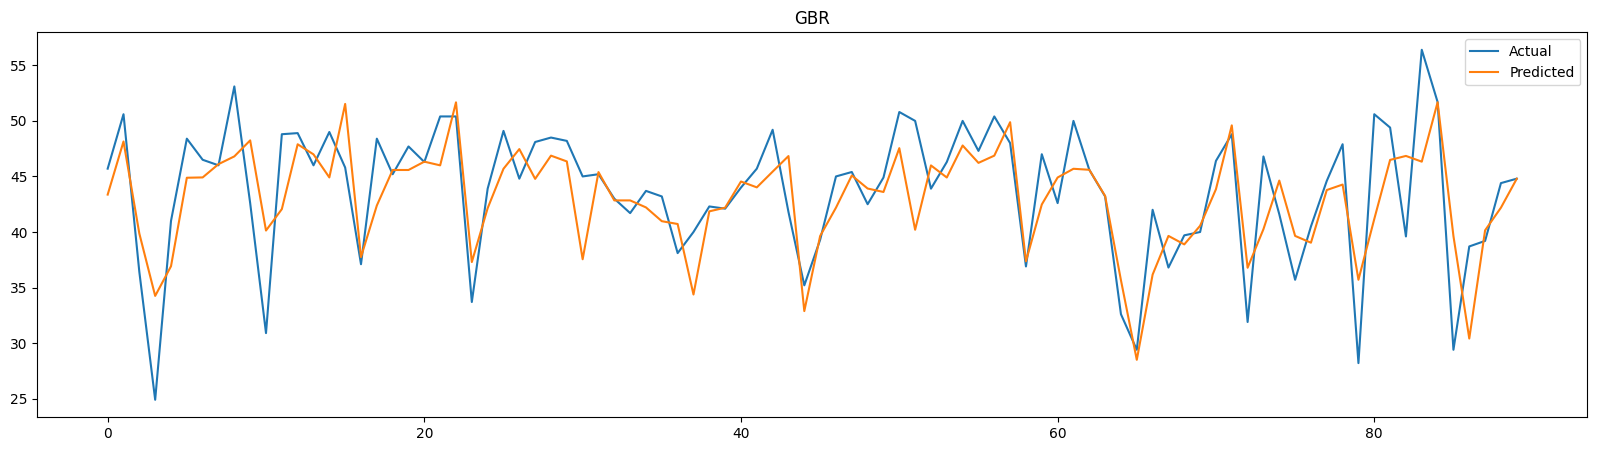

GBR   RMSE :  4.0919970418142775
GBR   MAPE :  0.0747703132434277
GBR   MAE :  3.0899487216913966


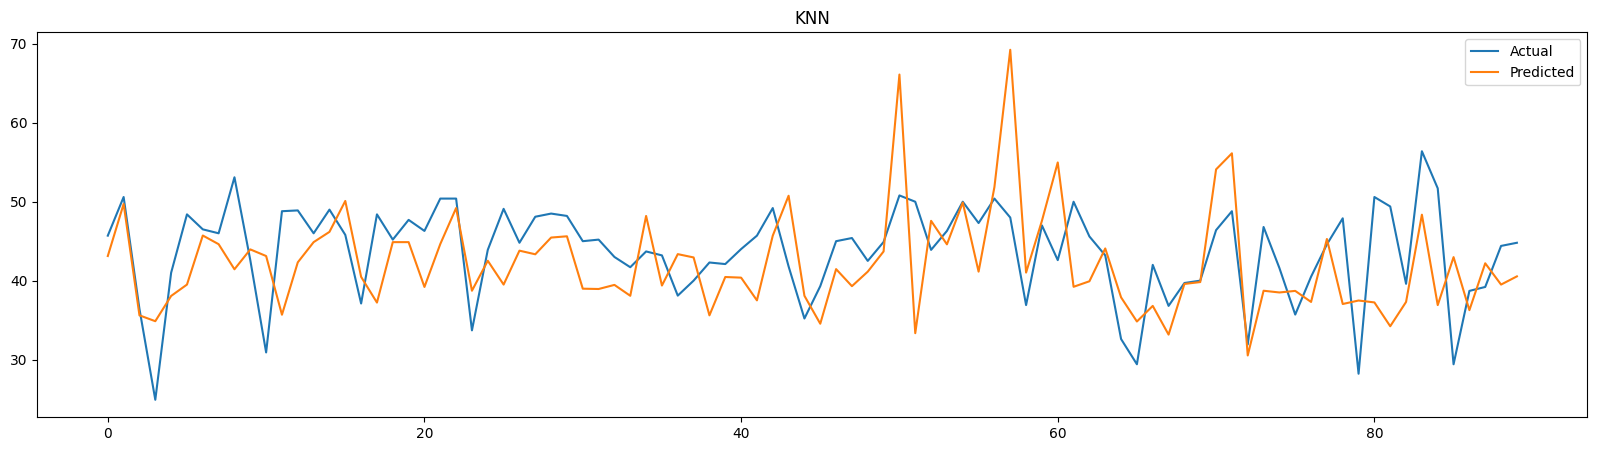

KNN   RMSE :  6.979494410214986
KNN   MAPE :  0.12553648475721563
KNN   MAE :  5.400444444444444


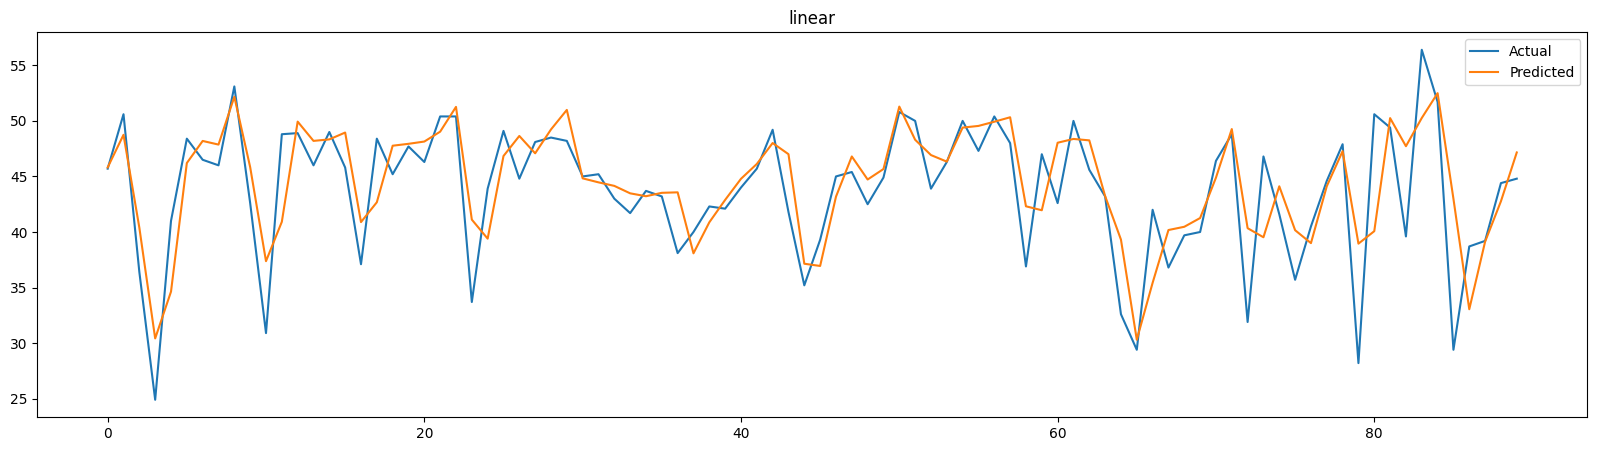

linear   RMSE :  3.9728798911775933
linear   MAPE :  0.07272769849800702
linear   MAE :  2.876990897356038


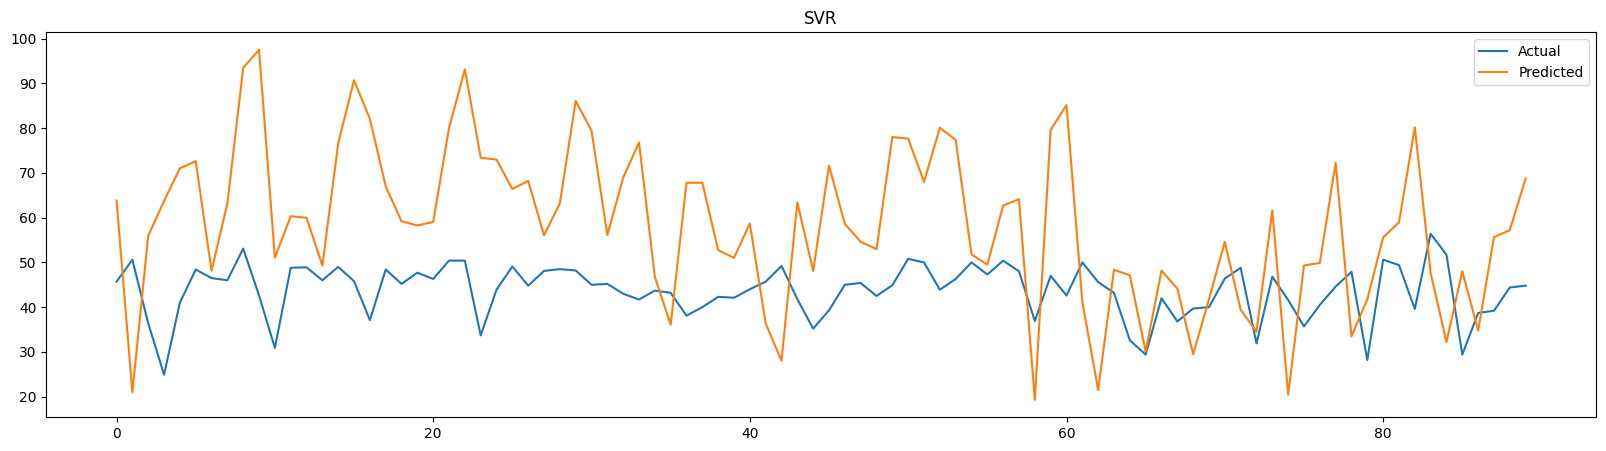

SVR   RMSE :  22.704912413776547
SVR   MAPE :  0.44849601481065754
SVR   MAE :  19.090354174024945


In [54]:
model_list = []
rmse_score = []
mape_score = []
mae_score = []

for key, values in models.items():
    nmodel = models[key]
    nmodel.fit(train_x, train_y)
    y_pred = nmodel.predict(test_x)
    plot_pred(test_y, y_pred, key)
    rmse = root_mean_squared_error(test_y, y_pred)
    mape = mean_absolute_percentage_error(test_y, y_pred)
    mae = mean_absolute_error(test_y, y_pred)
    model_list.append(key)
    rmse_score.append(rmse)
    mape_score.append(mape)
    mae_score.append(mae)
    print(key , "  RMSE : ", rmse)
    print(key , "  MAPE : ", mape)
    print(key , "  MAE : ", mae)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4677
[LightGBM] [Info] Number of data points in the train set: 2823, number of used features: 31
[LightGBM] [Info] Start training from score 3.661117


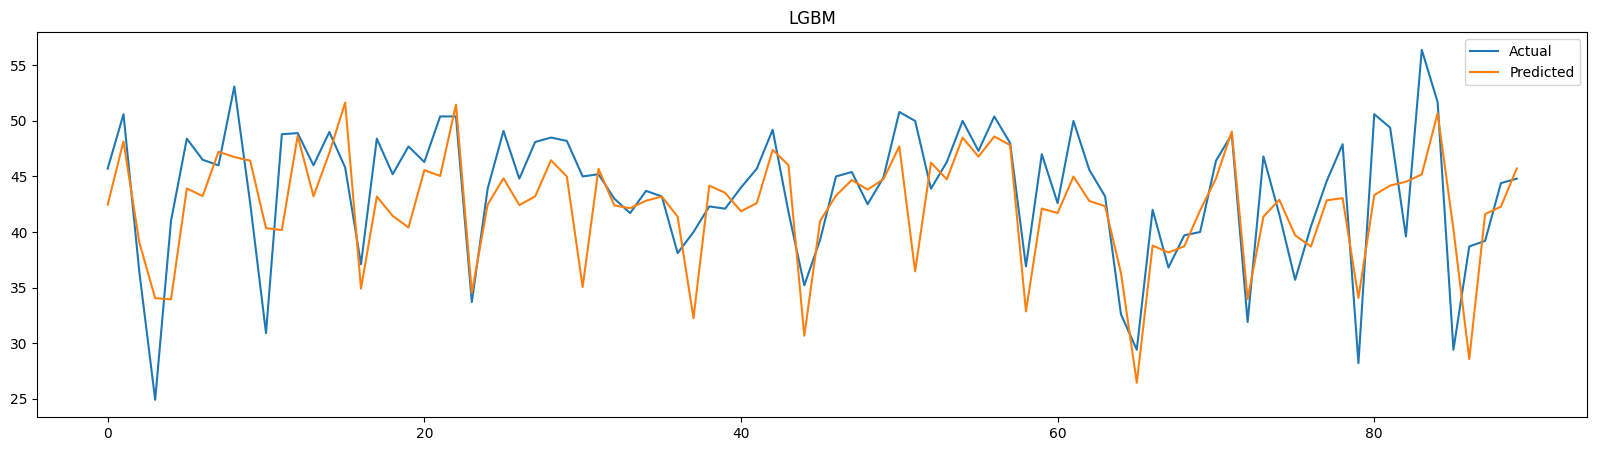

LGBM   RMSE :  4.460633747092279
LGBM   MAPE :  0.08193994268258938
LGBM   MAE :  3.416872989255585
[14:29:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "metric" } are not used.



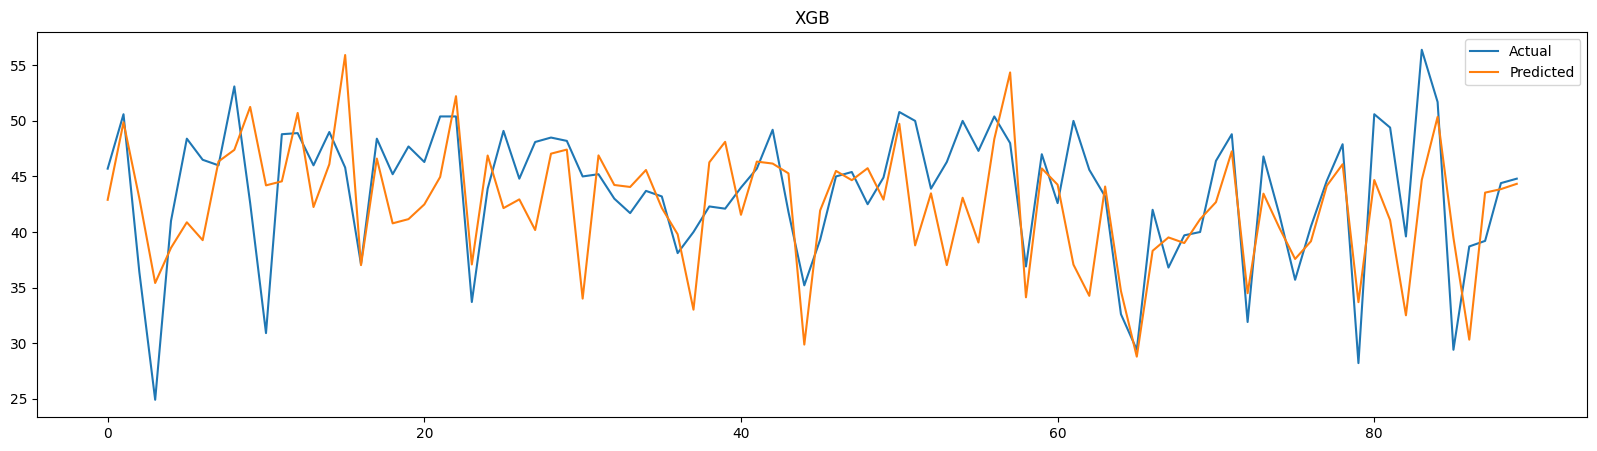

XGB   RMSE :  5.318816990848213
XGB   MAPE :  0.09704087743691758
XGB   MAE :  4.097374521891277
Learning rate set to 0.048238
0:	learn: 0.0741671	total: 2.35ms	remaining: 2.35s
1:	learn: 0.0714593	total: 3.97ms	remaining: 1.98s
2:	learn: 0.0690031	total: 5.56ms	remaining: 1.85s
3:	learn: 0.0665612	total: 6.83ms	remaining: 1.7s
4:	learn: 0.0641907	total: 8.16ms	remaining: 1.62s
5:	learn: 0.0619604	total: 9.89ms	remaining: 1.64s
6:	learn: 0.0599248	total: 11.6ms	remaining: 1.65s
7:	learn: 0.0580044	total: 13.6ms	remaining: 1.68s
8:	learn: 0.0561665	total: 15.4ms	remaining: 1.7s
9:	learn: 0.0544262	total: 16.7ms	remaining: 1.66s
10:	learn: 0.0527134	total: 18.1ms	remaining: 1.63s
11:	learn: 0.0510791	total: 19.8ms	remaining: 1.63s
12:	learn: 0.0495536	total: 21.3ms	remaining: 1.62s
13:	learn: 0.0481223	total: 22.9ms	remaining: 1.61s
14:	learn: 0.0467692	total: 24.6ms	remaining: 1.61s
15:	learn: 0.0453856	total: 26ms	remaining: 1.6s
16:	learn: 0.0441952	total: 27.9ms	remaining: 1.61s
17:	

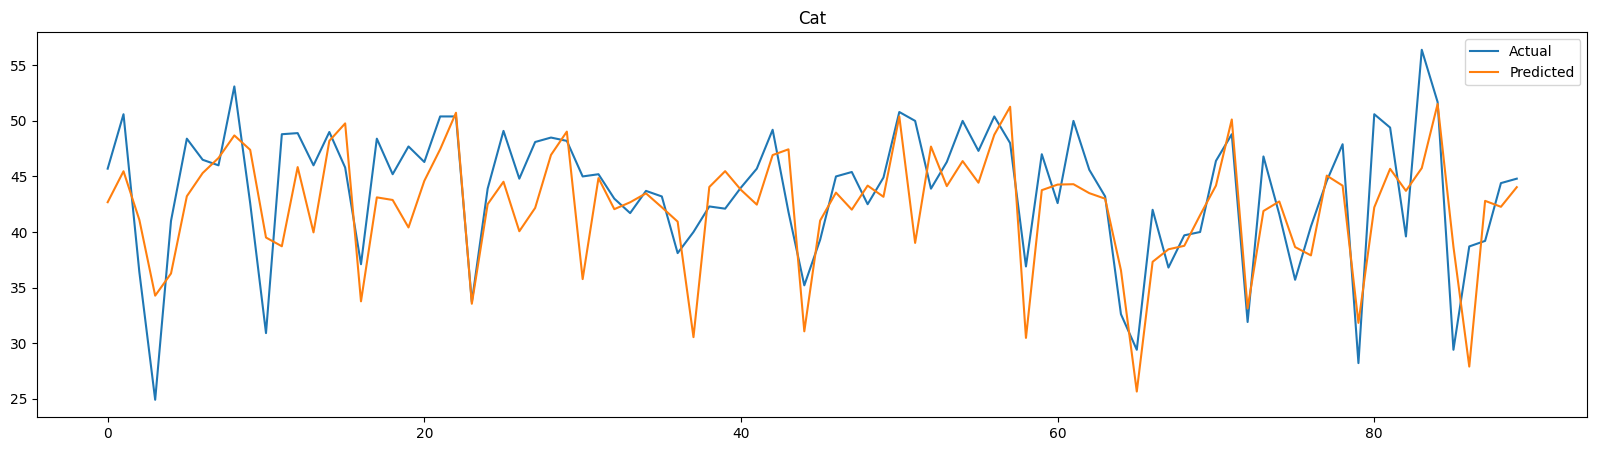

Cat   RMSE :  4.462856920279657
Cat   MAPE :  0.08395042094923906
Cat   MAE :  3.513238689824757


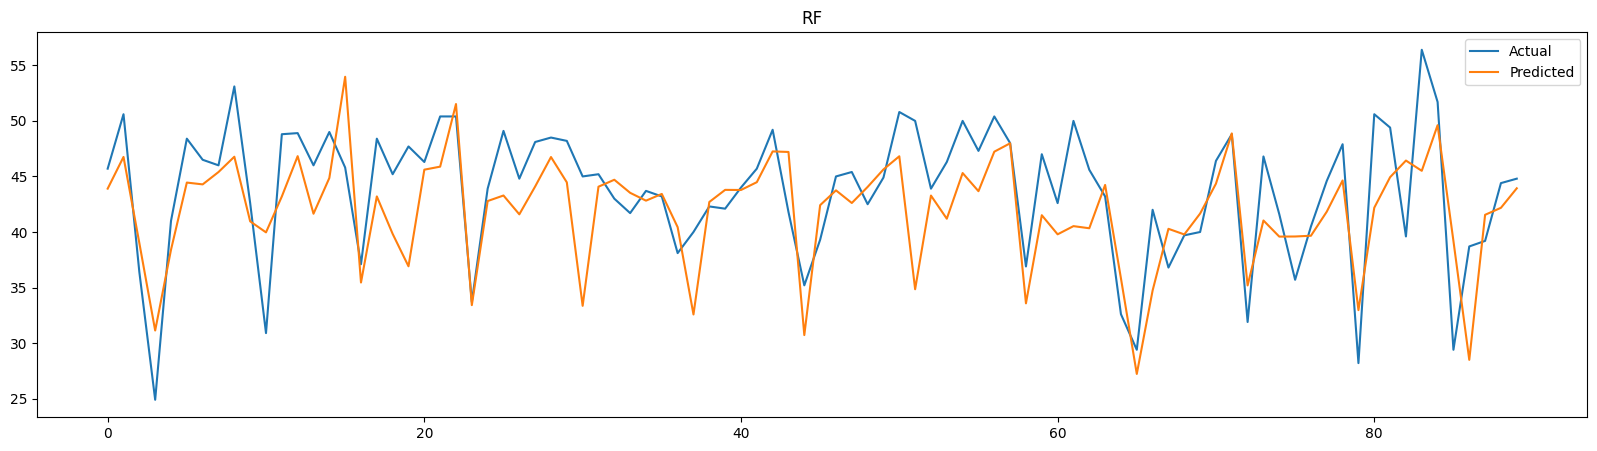

RF   RMSE :  4.787246527852064
RF   MAPE :  0.08726661543576865
RF   MAE :  3.7211705343267374


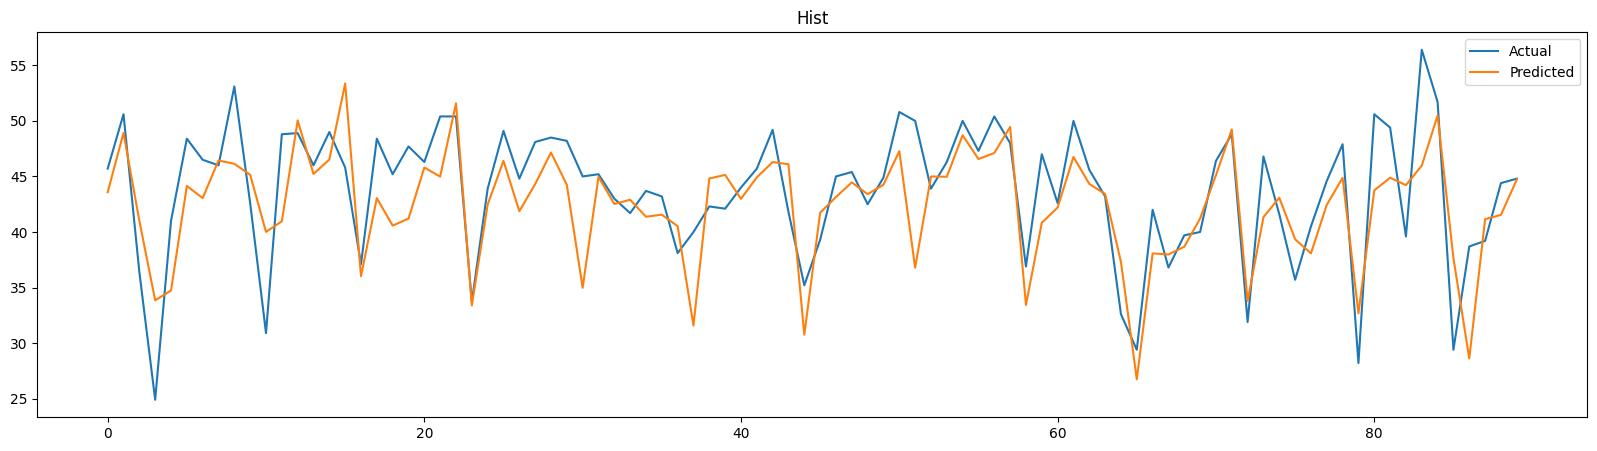

Hist   RMSE :  4.302533616887469
Hist   MAPE :  0.07862781471276062
Hist   MAE :  3.2921550100932406


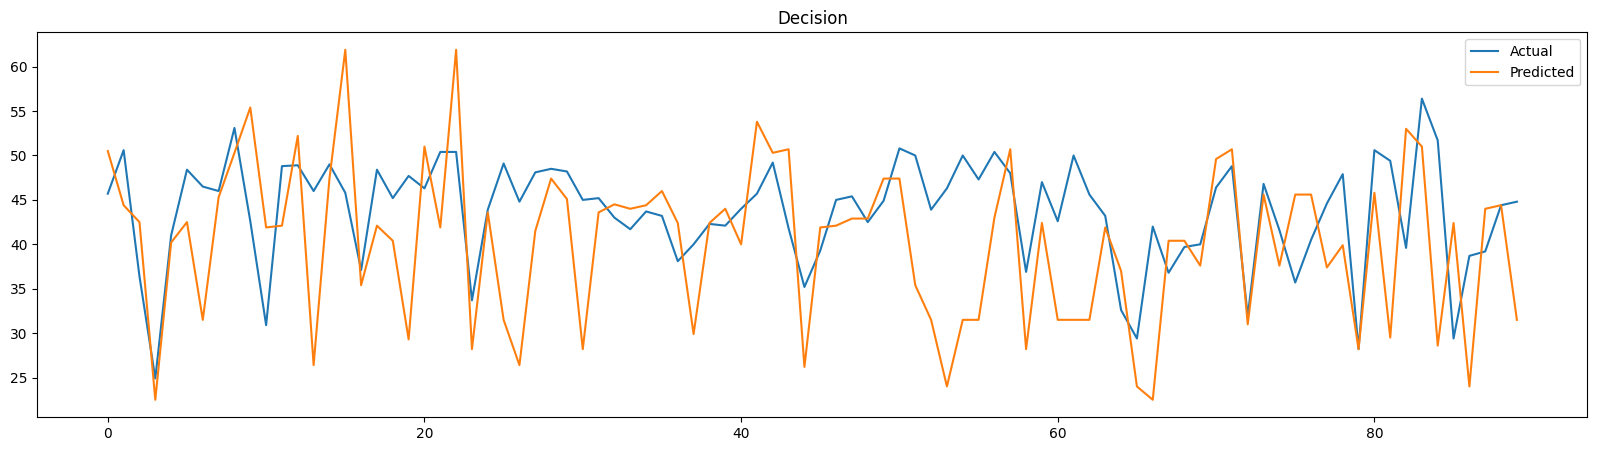

Decision   RMSE :  9.532459167380566
Decision   MAPE :  0.16587333115789168
Decision   MAE :  7.262222222222224


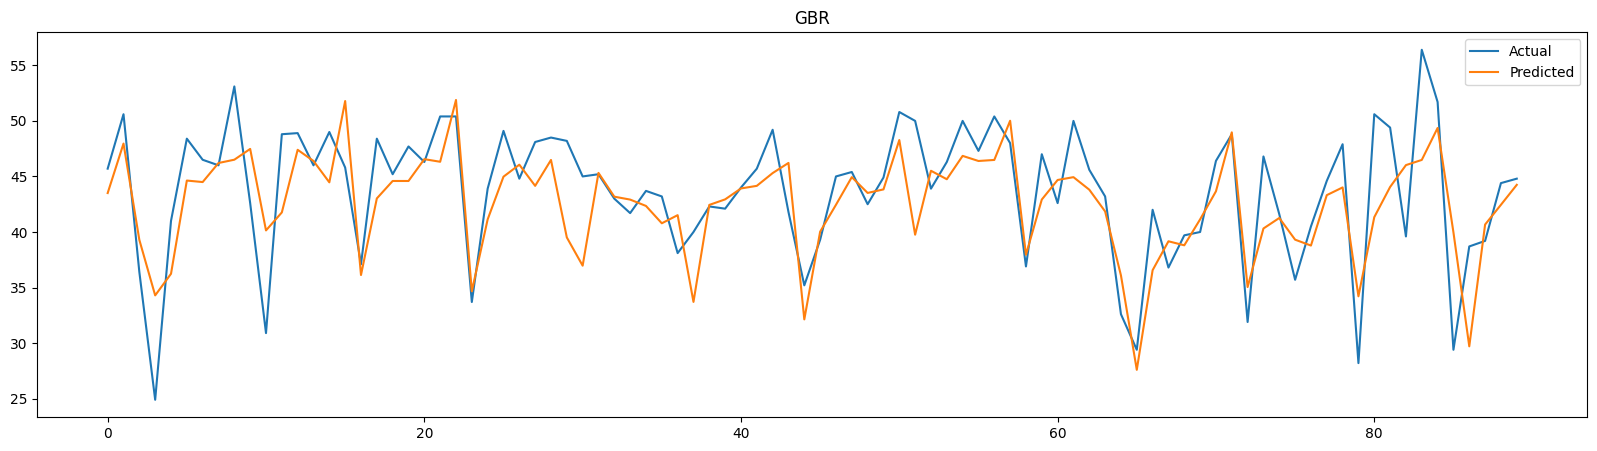

GBR   RMSE :  4.231446555515326
GBR   MAPE :  0.07782573687960244
GBR   MAE :  3.2573037247685717


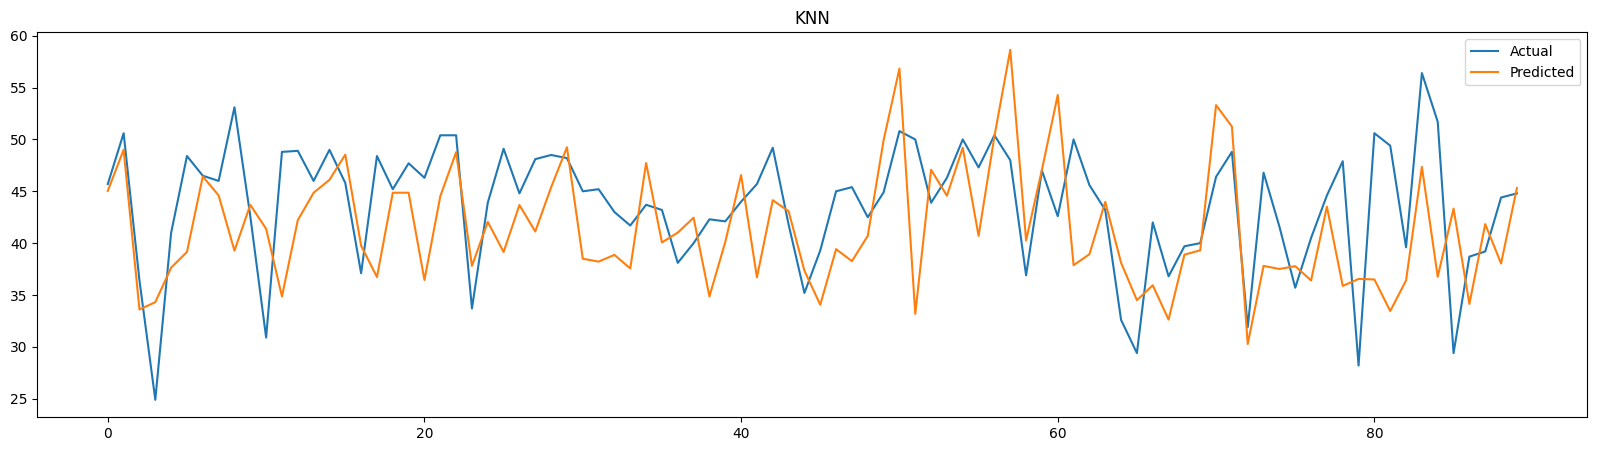

KNN   RMSE :  6.72200921755538
KNN   MAPE :  0.12188188722719671
KNN   MAE :  5.252039686534153


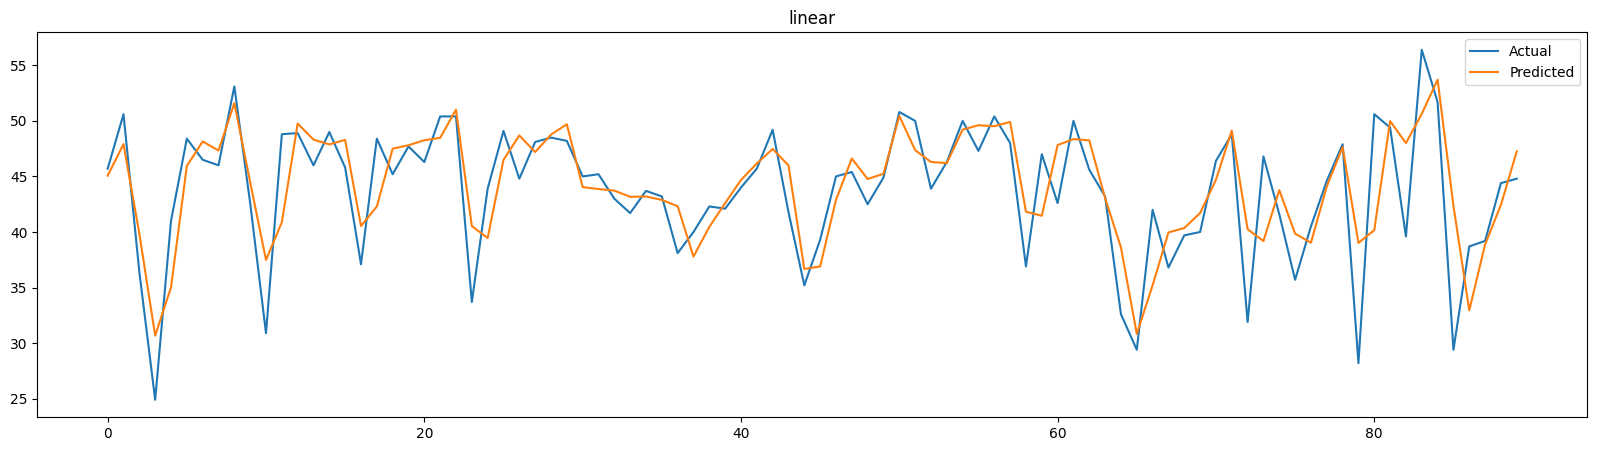

linear   RMSE :  3.8931826860891485
linear   MAPE :  0.07156551896098724
linear   MAE :  2.8417452296903365


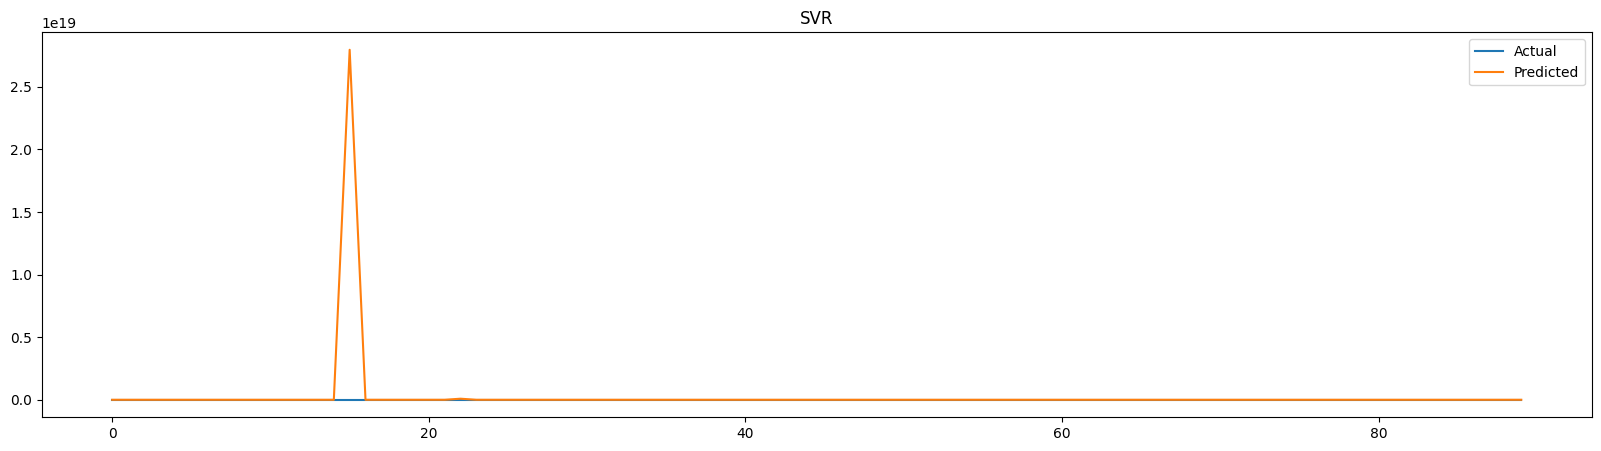

SVR   RMSE :  2.9480798594537426e+18
SVR   MAPE :  6803843086570398.0
SVR   MAE :  3.1170264587863917e+17


In [61]:
log_model_list = []
log_rmse_score = []
log_mape_score = []
log_mae_score = []

for key, values in models.items():
    nmodel = models[key]
    nmodel.fit(log_train_x, log_train_y)
    log_y_pred = nmodel.predict(log_test_x)
    plot_pred(np.expm1(log_test_y), np.expm1(log_y_pred), key)
    rmse = root_mean_squared_error(np.expm1(log_test_y), np.expm1(log_y_pred))
    mape = mean_absolute_percentage_error(np.expm1(log_test_y), np.expm1(log_y_pred))
    mae = mean_absolute_error(np.expm1(log_test_y), np.expm1(log_y_pred))
    log_model_list.append(key)
    log_rmse_score.append(rmse)
    log_mape_score.append(mape)
    log_mae_score.append(mae)
    print(key , "  RMSE : ", rmse)
    print(key , "  MAPE : ", mape)
    print(key , "  MAE : ", mae)

In [44]:
result_df = pd.DataFrame({'Model': model_list, 'RMSE': rmse_score, 'MAPE':mape_score, 'MAE':mae_score}).reset_index(drop=True)
result_df

,Model,RMSE,MAPE,MAE
0,LGBM,4.445136,0.080546,3.360885
1,XGB,4.743310,0.086816,3.628930
2,Cat,4.533564,0.086233,3.556435
3,RF,4.146898,0.074111,3.068044
4,Hist,4.227823,0.074525,3.102350
5,Decision,9.209011,0.157521,6.890000
6,GBR,4.092175,0.074808,3.091343
7,KNN,6.979494,0.125536,5.400444
8,linear,3.972880,0.072728,2.876991
9,SVR,22.704912,0.448496,19.090354


In [63]:
log_result_df = pd.DataFrame({'Model': log_model_list, 'RMSE': log_rmse_score, 'MAPE':log_mape_score, 'MAE':log_mae_score}).reset_index(drop=True)
log_result_df

,Model,RMSE,MAPE,MAE
0,LGBM,4.460634e+00,8.193994e-02,3.416873e+00
1,XGB,5.318817e+00,9.704088e-02,4.097375e+00
2,Cat,4.462857e+00,8.395042e-02,3.513239e+00
3,RF,4.787247e+00,8.726662e-02,3.721171e+00
4,Hist,4.302534e+00,7.862781e-02,3.292155e+00
5,Decision,9.532459e+00,1.658733e-01,7.262222e+00
6,GBR,4.231447e+00,7.782574e-02,3.257304e+00
7,KNN,6.722009e+00,1.218819e-01,5.252040e+00
8,linear,3.893183e+00,7.156552e-02,2.841745e+00
9,SVR,2.948080e+18,6.803843e+15,3.117026e+17


## 4. Hyperparameter Tuning

In [ ]:
import xgboost
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

xgb = xgboost.XGBRegressor(**xgb_optuna)
xgb_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.4, 0.7, 1.0],
    'colsample_bytree': [0.6, 1.0]
}

gs = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_grid,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    verbose=10,
)
gs.fit(log_train_x, log_train_y)

print('xgb_best_score:', gs.best_score_)
print("xgb_best_parameters:", gs.best_params_)
xgb_best = gs.best_estimator_

y_train_pred = xgb_best.predict(log_train_x)
y_test_pred = xgb_best.predict(log_test_x)

xgb_rmse_train = mean_squared_error(log_train_y, y_train_pred)**0.5
xgb_rmse_test = mean_squared_error(log_test_y, y_test_pred)**0.5
xgb_mae_train = mean_absolute_error(log_train_y, y_train_pred)
xgb_mae_test = mean_absolute_error(log_test_y, y_test_pred)
xgb_mape_train = mean_absolute_percentage_error(log_train_y, y_train_pred)
xgb_mape_test = mean_absolute_percentage_error(log_test_y, y_test_pred)
plot_pred(log_test_y, y_test_pred, 'xgb')
print('xgb')
errors = pd.DataFrame([[xgb_rmse_train,xgb_rmse_test],[xgb_mae_train,xgb_mae_test],[xgb_mape_train,xgb_mape_test]], index=['rmse','mae','mape'], columns=['train','test'])
errors